$$\textbf{ Simulações com Runge Kutta de }4^o \textbf{ordem}$$

$$ \text{Sistema de equações para Lorenz}: $$

$$ \dot{x} = \sigma(y - x) $$
$$ \dot{y} = x(\rho - z) - y $$
$$ \dot{z} = xy - \beta z $$

In [1]:
# Bibliotecas importadas
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import eigvals
from scipy import integrate

# Definindo Função do Sistema de lorenz
@jit
def lorenz(x, y, z, sigma, rho, beta):
    x_ponto = sigma * (y - x)
    y_ponto = x*(rho - z) - y
    z_ponto = x*y - beta*z
    return x_ponto, y_ponto, z_ponto

# Definindo Função RK4
@jit(nopython=True, parallel=True)
def rk4_lorenz(x0, y0, z0, sigma, rho, beta, tf, dt):
  t = np.arange(0, tf+dt, dt)
  tsize = len(t)
  x, y, z = np.zeros((3, tsize))

  x[0] = x0
  y[0] = y0
  z[0] = z0

  for i in range(tsize-1):
    k1, l1, m1 = lorenz( x[i], y[i], z[i], sigma, rho, beta)

    k2, l2, m2 = lorenz( x[i] + 0.5*k1*dt, y[i] + 0.5*l1*dt, z[i] + 0.5*m1*dt, sigma, rho, beta)

    k3, l3, m3 = lorenz( x[i] + 0.5*k2*dt, y[i] + 0.5*l2*dt, z[i] + 0.5*m2*dt, sigma, rho, beta)

    k4, l4, m4 = lorenz( x[i] + k3*dt, y[i] + l3*dt, z[i] + m3*dt, sigma, rho, beta)

    x[i+1] = x[i] + dt*(1/6)*(k1 + 2*k2 + 2*k3 + k4)
    y[i+1] = y[i] + dt*(1/6)*(l1 + 2*l2 + 2*l3 + l4)
    z[i+1] = z[i] + dt*(1/6)*(m1 + 2*m2 + 2*m3 + m4)

  return x, y, z, t

$$ \textbf{ Simualções 2D} $$

$$ \text{Animação das trajetórias com diferentes posições } x_0 \text{ iniciais}$$

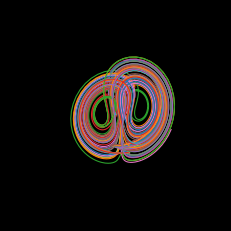

In [20]:
# Bibliotecas importadas
import matplotlib as mpl
from matplotlib import rc
import matplotlib.animation as animation

# Set para maiores imagens
mpl.rcParams['animation.embed_limit'] = 2**128
rc('animation', html='jshtml')

# Condições iniciais
sigma = 10
beta = 8/3
rho = 28
tf = 800
dt = 0.01

# Quantidade de trajetórias
N_trajetoria = 45
# Valores de x0 para as trajetórias
x0 = -15 + 40 * np.random.random(N_trajetoria)


x, y, z, t = [], [], [], []
# Criando Simulações
for i in range(len(x0)):
    x_i, y_i, z_i, t_i = rk4_lorenz(x0=x0[i], y0=1, z0=10, sigma=sigma, rho=rho, beta=beta, tf=tf, dt=dt)
    x.append(x_i)
    y.append(y_i)
    z.append(z_i)
    
# Inciando figuras
fig = plt.figure('Atrator de Lorenz', facecolor = 'k', figsize = (6, 4))
fig.tight_layout()
ax = fig.add_subplot(projection='3d')

# Criando a animação
def update(i):  
    ax.view_init(-6, -56 + i/3)
    ax.clear()
    ax.set(facecolor = 'k')
    ax.set_axis_off()
    for j in range( len(x) ):
        ax.plot(x[j][:i], y[j][:i], z[j][:i], lw = 1.1)

anim = animation.FuncAnimation(fig, update, np.arange(200), interval=2)

# Plotar animação
anim

$$ \textbf{ Simualções 3D} $$

$$ \text{Uma das bibliotecas uteis para esse tipo de visualização é a Vpython.} $$

$$ \text{Para utiliza-la, podemos ir no site:  } \href{https://www.glowscript.org}{Clique Aqui}$$

$$ \textbf{Análise dos autovalores}$$

$$ \text{Pontos fixos} \to (x, y, z) = \left( \pm \sqrt{\beta(\rho-1)}; \pm \sqrt{\beta(\rho-1)}; \rho-1 \right) $$

$$ \textbf{Matriz Jacobiana} $$

$$
\begin{pmatrix}
-\sigma & \sigma & 0 \\
1 & -1 & -\sqrt{\beta(\rho-1)}\\
\sqrt{\beta(\rho-1)} & \sqrt{\beta(\rho-1)} & -\beta
\end{pmatrix}
$$


$$ \textbf{A partir do valor da mudança de }\rho \textbf{, temos mudança da dinâmica do sistema, onde os autovalores novos surgem} $$



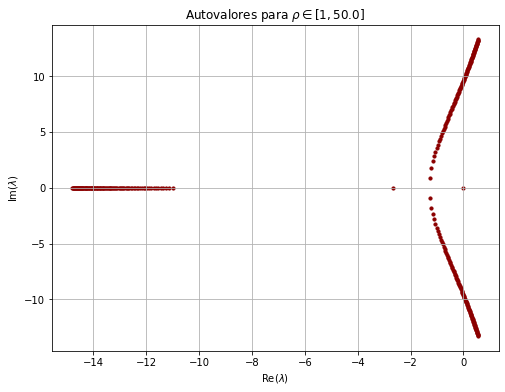

In [2]:
# Se ==True, mostra o valor de r junto de seus autovalores, separados por parte real e imaginaria
mostrar_pontos = False
sigma = 10
beta = 8/3

r_max = 50.5
ra = np.arange(1, r_max, 0.5)

# Pontos fixos em x,y
def xstar(r):
  return np.sqrt( beta*(r-1) )
  
# Retorna matriz jacobiana de lorenz calculada nos pontos fixos
def J(r):
  # P.F => (x, y, z) = [+-xstar, +-xstar, rho-1]
  return  np.array([[-sigma,sigma,0],[1,-1,-xstar(r)],[xstar(r),xstar(r),-beta]])

# Plot dos autovalores nos pontos fixos
fig = plt.figure(figsize=(8,6))
Imag = False
for r in ra:
    L = eigvals(J(r))
    if mostrar_pontos==True:
        print(f'r = {r}, Real=>|{np.real(L)[0]:.2f}; {np.real(L)[1]:.2f}; {np.real(L)[2]:.2f}| Imaginario=> |{np.imag(L)[0]:.2f}; {np.imag(L)[1]:.2f}; {np.imag(L)[2]:.2f}|  ')
    plt.scatter(np.real(L), np.imag(L),s=10,color='darkred')

plt.xlabel('Re$(\lambda)$')
plt.ylabel('Im$(\lambda)$')
plt.title(fr'Autovalores para $\rho \in[1,{max(ra)}]$')
plt.grid()
plt.show()

$$\textbf{Podemos comparar com o diagrama de bifurcação para }\rho$$
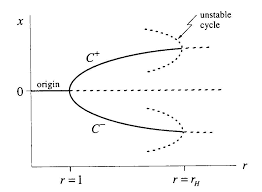

$$ \textbf{Podemos analisar os pontos fixos sitados anteriormente, reproduzindo o mesmo gráfico} $$

$$ \text{ Usando as mesmas condições iniciais, colocamos os mesmos eixos para } C^+ \text{e } C^- $$

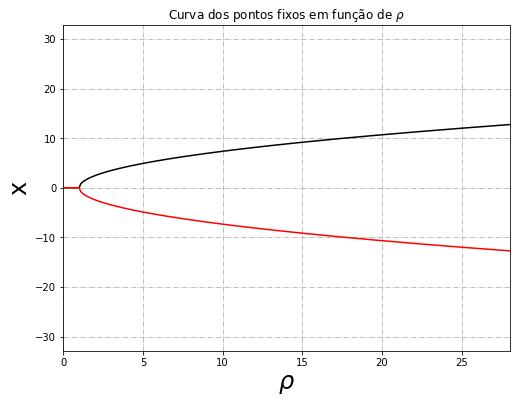

In [13]:
sigma = 10
beta = 6
dr = 0.1  # parameter step size
rho = np.arange(0, 150, dr)  # parameter range
x0, y0, z0 = 1, 1, 1

r_lista = []

#
def xstar(r):
  return np.sqrt( beta*(r-1) )

C_mais, C_menos = [], []

for R in rho:
    xs, ys, zs, t = rk4_lorenz(x0, y0, z0, sigma=sigma, rho=R, beta=beta, tf=50, dt=0.001)
    if R>=1:
        C_mais.append( xstar(R) )
        C_menos.append( -xstar(R) )
        r_lista.append(R)
    elif R>0 and R<=1:
        C_mais.append( 0 )
        C_menos.append( 0 )
        r_lista.append(R)

    
plt.figure(figsize=(8,6))

plt.plot(r_lista, C_mais, color="black")
plt.plot(r_lista, C_menos, color="red")
plt.title(r'Curva dos pontos fixos em função de $\rho$')
plt.grid(linestyle='-.')
plt.xlabel(r'$\rho$', size=24)
plt.ylabel('x', size=24)
plt.xlim(0,28)
#plt.ylim(-10,10)
plt.show()

$$ \textbf{Simualçao gráfico de bifurção (eixo z)} $$

$$ \text{ Estaremos simulando varias trajetórias para valores de $\rho$.} $$

$$ \text{ Em cada uma delas, pegaremos os valores em que a derivada é zero.}\\ \text{Para conseguirmos esse efeito, escolhermos os pontos dentro da simulação em de máximo e mínimo, com seu $\rho$ correspondente. } $$

$$ \text{Nas series temporais vemos como:} $$
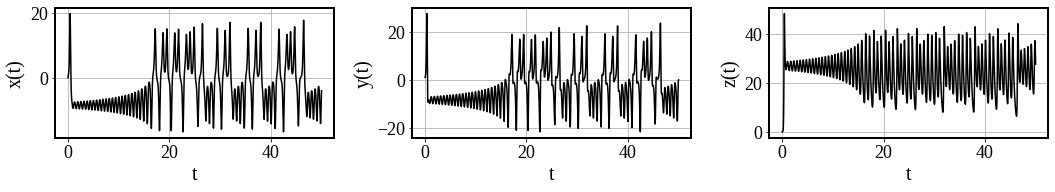


$$ \text{Esses mesmos pontos de minímo e maximo são nas trajetórias:} $$

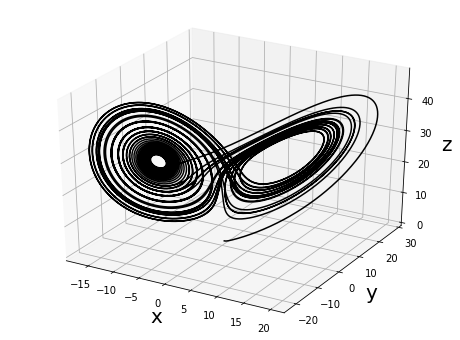


In [101]:
# Condições iniciais
sigma = 10
dr = 0.1
rho = np.arange(0, 100, dr)
beta = 8/3
x0, y0, z0 = 1, 1, 1


r_maximo = []
z_maximo = []
r_minimo  = []
z_minimo  = []

for R in rho:
    xs, ys, zs, t = rk4_lorenz(x0, y0, z0, sigma=sigma, rho=R, beta=beta, tf=50, dt=0.001)

    for i in range(1, len(xs) - 1):
        # Pegamos valores de maximo do ponto dentro da trajetória
        if zs[i - 1] < zs[i] and zs[i] > zs[i + 1]:
            r_maximo.append(R)
            z_maximo.append(zs[i])
            
        # Pegamos valores de maximo do ponto dentro da trajetória
        elif zs[i - 1] > zs[i] and zs[i] < zs[i + 1]:
            r_minimo.append(R)
            z_minimo.append(zs[i])

    # Valores finais são usados como condições iniciais para a próxima interação ficar perto do atrator
    xs[0], ys[0], zs[0] = xs[i], ys[i], zs[i]

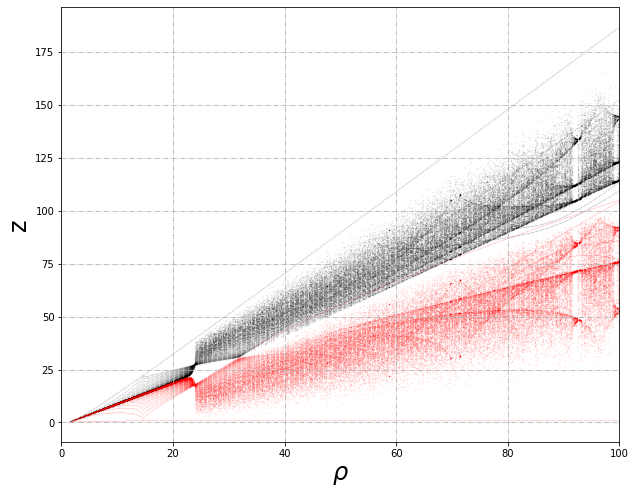

In [105]:
# Configurações para plot
fig = plt.figure(figsize=(10,8))

plt.scatter(r_maximo, z_maximo, color="black", s=0.1, alpha=.1)
plt.scatter(r_minimo, z_minimo, color="red", s=0.1, alpha=.1)

plt.grid(linestyle='-.')

plt.xlabel(r'$\rho$', size=24)
plt.ylabel('z', size=24)
plt.xlim(0,100)
plt.show()

$$ \textbf{Simualçao gráfico de bifurção (eixo x)} $$

In [103]:
# Condições iniciais
sigma = 10
dr = 0.1
rho = np.arange(0, 100, dr)
beta = 8/3
x0, y0, z0 = 1, 1, 1

r_maximo_x = []
x_maximo = []
r_minimo_x  = []
x_minimo  = []

for R in rho:
    xs, ys, zs, t = rk4_lorenz(x0, y0, z0, sigma=sigma, rho=R, beta=beta, tf=50, dt=0.001)

    for i in range(1, len(xs) - 1):
        # Pegamos valores de maximo do ponto dentro da trajetória
        if xs[i - 1] < xs[i] and xs[i] > xs[i + 1]:
            r_maximo_x.append(R)
            x_maximo.append(xs[i])
            
        # Pegamos valores de maximo do ponto dentro da trajetória
        elif xs[i - 1] > xs[i] and xs[i] < xs[i + 1]:
            r_minimo_x.append(R)
            x_minimo.append(xs[i])

    # Valores finais são usados como condições iniciais para a próxima interação ficar perto do atrator
    xs[0], ys[0], zs[0] = xs[i], ys[i], zs[i]

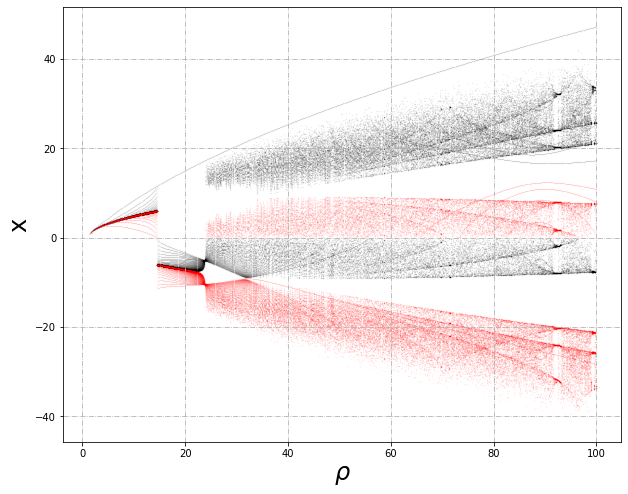

In [104]:
# Configurações para plot
fig = plt.figure(figsize=(10,8))

plt.scatter(r_maximo_x, x_maximo, color="black", s=0.1, alpha=.1)
plt.scatter(r_minimo_x, x_minimo, color="red", s=0.1, alpha=.1)

plt.grid(linestyle='-.')

plt.xlabel(r'$\rho$', size=24)
plt.ylabel('x', size=24)
plt.show()